In [31]:
import nltk
import pickle
import torch
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

position_words =['right', 'left', 'top', 'bottom', 'middle', 'mid', 'front', 'closest', 'nearest', 'center', 'central',
                               'corner', 'upper', 'back', 'behind', 'far', 'leftmost', 'lower', 'low', 'rightmost',
                               'farthest', 'furthest', 'next', 'last', 'up', 'above', 'below', 'down', 'side']


color_words = ['white', 'green', 'blue', 'red', 'yellow', 'black', 'brown', 'pink', 'dark', 'darker', 'orange',
                            'gray', 'purple', 'beige', 'bright']

size_words = ["big", "bigger", "small", "smaller", "tall", "taller", "large", "larger", "little", "short", "shorter",
                           'tiny', "long", "longer", 'huge']

In [2]:
def load_data(model,mode, dataset, split):
#load predicted and gold bounding boxes

    try:

        #the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
            pred_bbox_list=list(pickle.load(f))

        if mode=="non_inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))

        elif mode == "inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]
            
        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)
                    

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


In [3]:
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("ReSc","inc","unc","val")


In [4]:
#group sentences that belong to one incremental unit
def group_by_increment(bbox_list,inc_len):
    counter=0
    group_list=[]
    for i in inc_len:
        
        group_list.append(bbox_list[counter:counter+i])
        counter=counter+i
    return group_list

model_group=group_by_increment(model,inc_len)

In [5]:
#split up the list into entries where each guess is correct,wrong or mixed
def split_correct(binary_grouped):
    only_one=[]
    only_zero=[]
    mixed=[]
    for index,entry in enumerate(binary_grouped):
        if all(p == 1 for p in entry):
            only_one.append(index)
        elif all (p ==0 for p in entry):
            only_zero.append(index)
        else:
            mixed.append(index)
    return only_one,only_zero,mixed

only_one,only_zero,mixed=split_correct(binary_grouped)


In [6]:
def get_change_words(model_group,mixed_values,mixed):
    
    change_right=[]
    change_wrong=[]
    
    for entry,indi in zip(mixed_values,mixed):
        for i in range(len(entry)-1):
            
            m=model_group[indi]
            
            if entry[i] == entry[i + 1]:
                #print("eqaul")
                pass
            
            elif entry[i]==0 and entry[i+1]==1:
                change_right.append(m[i+1][3].split()[-1])

            elif entry[i]==1 and entry[i+1]==0:
                change_wrong.append(m[i+1][3].split()[-1])
                
            
            else:
                print("Something is very wrong.")

    return change_right,change_wrong

def split_words(word_list):
    

    stopwords_english = stopwords.words("english")
    stop = [i for i in word_list if i in stopwords_english]
    position = [i for i in word_list if i in position_words]
    color = [i for i in word_list if i in color_words]
    size = [i for i in word_list if i in size_words]
    rest = [i for i in word_list if i not in stopwords_english and i not in position_words and i not in color_words and i not in size_words]


    return stop, position, color, size, rest

#helper function to make code more readable 
#calculates the ratio of stop,position,color and size words 
#to all words in the first position

def calculate_ratios(stop, position,color,size, rest, first_word):
                
                stop_ratio = round(len(stop) / len(first_word), 2)
                pos_ratio = round(len(position) / len(first_word), 2)
                color_ratio = round(len(color) / len(first_word), 2)
                size_ratio = round(len(size) / len(first_word), 2)
                rest_ratio = round(len(rest) / len(first_word), 2)
                return stop_ratio, pos_ratio,color_ratio,size_ratio, rest_ratio


In [17]:
def change_words(binary_grouped,model_group):
    stop_wrong,pos_wrong,rest_wrong,color_wrong,size_wrong=([] for i in range(5))
    stop_right,pos_right,rest_right,color_right,size_right=([] for i in range(5))


    # Split up the list into entries where each guess is correct, wrong, or mixed
    right_only = []
    wrong_only = []
    mixed_only = []
    mixed_values=[]
    for index, entry in enumerate(binary_grouped):
        if all(p == 1 for p in entry):
            right_only.append(index)
        elif all(p == 0 for p in entry):
            wrong_only.append(index)
        else:
            mixed_only.append(index)
            mixed_values.append(entry)

    model_group=group_by_increment(model,inc_len)
    change_right,change_wrong=get_change_words(model_group,mixed_values,mixed_only)
    
    #print("right",change_right)
    all_entries = [change_right,change_wrong]
    types = ["change_right","change_wrong"]


    #loop through the right,wrong,mixed lists and make lists for each  word condition
    for lst, typ in zip(all_entries, types):
        stop, position,color,size, rest = split_words(lst)
        stop_ratio, pos_ratio,color_ratio,size_ratio,rest_ratio = calculate_ratios(stop, position,color,size,rest, lst)

        if typ == "change_wrong":
            stop_wrong.append(stop_ratio)
            pos_wrong.append(pos_ratio)
            color_wrong.append(color_ratio)
            size_wrong.append(size_ratio)
            rest_wrong.append(rest_ratio)
        elif typ == "change_right":
            stop_right.append(stop_ratio)
            pos_right.append(pos_ratio)
            color_right.append(color_ratio)
            size_right.append(size_ratio)
            rest_right.append(rest_ratio)


    pos_all=[pos_right,pos_wrong]
    color_all=[color_right,color_wrong]
    size_all=[size_right,size_wrong]
    stop_all=[stop_right,stop_wrong]
    rest_all=[rest_right,rest_wrong]
    
    
    return (change_right,change_wrong)
    #return pos_all,color_all,size_all,stop_all,rest_all


#pos_all,color_all,size_all,stop_all,rest_all=change_words(binary_grouped,model_group)
change_right,change_wrong=change_words(binary_grouped,model_group)

TypeError: 'int' object is not iterable

In [8]:

pos_change_right=[]       
for word in change_right:
    if word in position_words:
        pos_change_right.append(word)

pos_change_wrong=[]       
for word in change_wrong:
    if word in position_words:
        pos_change_wrong.append(word)




In [9]:
count_pos_change_right=Counter(pos_change_right)
count_pos_change_right.most_common()

[('right', 694),
 ('left', 684),
 ('middle', 78),
 ('bottom', 76),
 ('front', 70),
 ('back', 69),
 ('top', 64),
 ('far', 35),
 ('behind', 32),
 ('center', 29),
 ('above', 12),
 ('closest', 12),
 ('lower', 10),
 ('next', 6),
 ('upper', 6),
 ('corner', 6),
 ('down', 5),
 ('furthest', 3),
 ('nearest', 3),
 ('below', 3),
 ('farthest', 3),
 ('up', 2),
 ('side', 2),
 ('last', 1),
 ('rightmost', 1)]

In [10]:
def split_attribute(only_one,only_zero,mixed,model_group,attri):
    one=[]
    zero=[]
    mix=[]

    for i in range(len(model_group)):
        sent=model_group[i][-1][3]

        if attri=="Position":
            attribute_word=position_words
        elif attri=="Size":
            attribute_word=size_words
        elif attri=="Color":
            attribute_word=color_words
        elif attri=="Stopwords":
            attribute_word=stop_words
        else:
            print(attri,"is not valid. Valid words are: Position,Size,Color,Stopwords")
            break
        
        
        for word in attribute_word:
            if word in sent.split():
                
                if i in only_one:
                    one.append(word)
                
                elif i in only_zero:
                    zero.append(word)

                elif i in mixed:
                    mix.append(word)
                
                else:
                    print("Index",i,"does not appear in any list")

    return one,zero,mix

one,zero,mix=split_attribute(only_one,only_zero,mixed,model_group,"Position")


In [11]:
one_count=Counter(one)
#one_count.most_common()

zero_count=Counter(zero)
#zero_count.most_common()

for item, count in one_count.items():
    one_count[item] /= len(only_one)

for item, count in zero_count.items():
    zero_count[item] /= len(only_zero)

    


In [12]:
def avg_counter(counter_list):

    # Initialize an average Counter with zeros
    average_counter = Counter()

    # Iterate through each Counter in the list
    for counter in counter_list:
        # Iterate through items in the Counter and add frequencies to the average Counter
        for item, frequency in counter.items():
            average_counter[item] += frequency

    # Divide frequencies in the average Counter by the number of Counters
    num_counters = len(counter_list)
    for item in average_counter:
        average_counter[item] /= num_counters

    return average_counter

#avg_counter(zero_list)

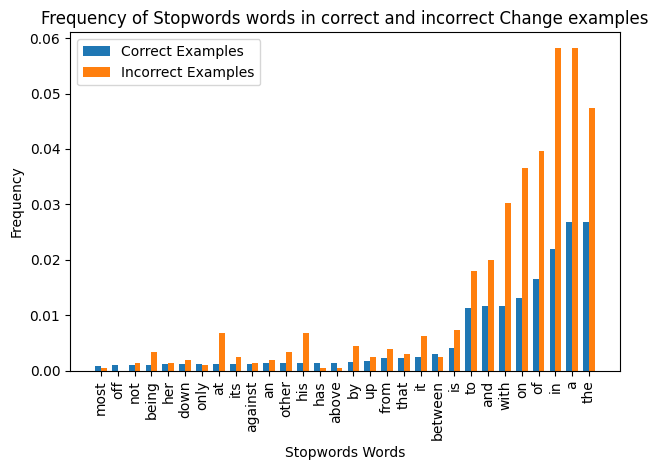

In [42]:
def plot_freq(one_count,zero_count,attri,setting):

    # Get the set of unique color labels from both Counter objects
    all_labels = set(one_count.keys()) | set(zero_count.keys())

    # Calculate the frequencies for each color label, handling missing data
    values1 = [one_count[label] if label in one_count else 0 for label in all_labels]
    values2 = [zero_count[label] if label in zero_count else 0 for label in all_labels]

    # Sort the combined data based on frequency from data1 in ascending order
    sorted_combined = sorted(zip(all_labels, values1, values2), key=lambda x: x[1])

    # Extract labels and sorted values for both data sets
    labels, sorted_values1, sorted_values2 = zip(*sorted_combined)

    if attri=="Stopwords":
        labels = labels[-30:]
        sorted_values1 = sorted_values1[-30:]
        sorted_values2 = sorted_values2[-30:]

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Set the positions and width for the bars
    positions = range(len(labels))
    width = 0.35

    # Create the bar plots for the combined and sorted Counter data
    ax.bar(positions, sorted_values1, width, label="Correct Examples")
    ax.bar([pos + width for pos in positions], sorted_values2, width, label="Incorrect Examples")

    # Set labels, title, and legend
    ax.set_xlabel(attri+' Words')
    ax.set_ylabel('Frequency')
    ax.set_title("Frequency of "+attri+" words in correct and incorrect " +setting+" examples")
    ax.set_xticks([pos + width/2 for pos in positions])
    ax.set_xticklabels(labels, rotation=90 )
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_freq(one_count,zero_count,"Stopwords","Change")

In [34]:
def split_attri_change(change_right,change_wrong,attri):
    
    if attri=="Position":
            attribute_word=position_words
    elif attri=="Size":
        attribute_word=size_words
    elif attri=="Color":
        attribute_word=color_words
    elif attri=="Stopwords":
        attribute_word=stop_words
    else:
        print(attri,"is not valid. Valid words are: Position,Size,Color,Stopwords")

    pos_change_right=[]       
    for word in change_right:
        if word in attribute_word:
            pos_change_right.append(word)

    pos_change_wrong=[]       
    for word in change_wrong:
        if word in attribute_word:
            pos_change_wrong.append(word)


    return pos_change_right,pos_change_wrong


unctestB
unctestA
uncval
unc+testB
unc+testA
unc+val
gref_umdval
gref_umdtest
grefval


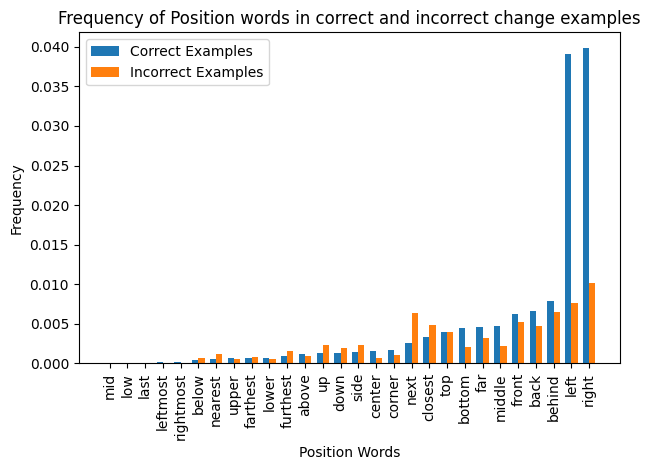

In [46]:
one_list=[]
zero_list=[]
attribute="Position"
setting="change"
mode="inc"
model_input="TVG"
split_list=["testB","testA","val","test"]
dataset_list=["unc","unc+","gref_umd","gref"]
#dataset_list=["unc"]

pos_all,color_all,size_all,stop_all,rest_all=([] for i in range(5))


#load the data
for file in dataset_list:
    for split in split_list:
    
        #if the data set does not exist ignore
        pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped= load_data(model_input,mode,file,split)
        if pred_bbox_list==-1 or target_bbox_list==-1:
             
             pass
        
        else:
        
            print(file+split)

            model_group=group_by_increment(model,inc_len)
            

            if setting=="all":
                only_one,only_zero,mixed=split_correct(binary_grouped)
                one,zero,mix=split_attribute(only_one,only_zero,mixed,model_group,attribute)

            elif setting=="change":
                change_right,change_wrong=change_words(binary_grouped,model_group)
                one,zero=split_attri_change(change_right,change_wrong,attribute)

            one_count=Counter(one)
            #one_count.most_common()

            zero_count=Counter(zero)
            #zero_count.most_common()

            for item, count in one_count.items():
                one_count[item] /= len(only_one)
            
            one_list.append(one_count)



            for item, count in zero_count.items():
                zero_count[item] /= len(only_zero)
            
            zero_list.append(zero_count)


one_avg=avg_counter(one_list)
zero_avg=avg_counter(zero_list)

plot_freq(one_avg,zero_avg,attribute,setting)


                

            
                        

            